**Sources of information** (last update)

In [132]:
#@title { vertical-output: true, display-mode: "form" }
import pandas as pd
from datetime import datetime, timedelta


# Consider adding:
#  https://github.com/COVID19Tracking

# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
# FIPS, Admin2, Province_State, Country_Region, Last_Update, Lat, Long_, Confirmed, Deaths, Recovered, Active, Combined_Key
# Issue: US and others are broken down, while Italy for example is whole
def load_latest_johnhopkins_daily():
    tries = 3
    try_date_utc = datetime.utcnow()
    while True:
        try:
            loc_template = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/%m-%d-%Y.csv"
            try_url = try_date_utc.strftime(loc_template)
            df = pd.read_csv(try_url)
            return also_print_df(df, "John Hopkins", try_date_utc)
        except:
            try_date_utc = try_date_utc - timedelta(days=1)
            tries = tries - 1
            if tries is 0:
                print("Out of tries looking for John Hopkins' data (walking back 1 day at a time)")
                exit(1)


# https://github.com/open-covid-19
#  Date, CountryCode, CountryName, RegionCode, RegionName, Confirmed, Deaths, Latitude, Longitude, Population --- sorted by date, ascending
def load_latest_opencovid_feed():
    loc_template = "https://raw.githubusercontent.com/open-covid-19/data/master/output/data.csv"
    df = pd.read_csv(loc_template)
    last_date = datetime.strptime(df.iloc[-1]['Date'], '%Y-%m-%d')
    return also_print_df(df, "Open COVID-19", last_date)


# https://github.com/pcm-dpc/COVID-19/
#  data, stato, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_guariti, deceduti, totale_casi, tamponi, note_it, note_en
def load_latest_italian_dpc_nationwide_by_date():
    loc_template = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
    df = pd.read_csv(loc_template)
    last_date = datetime.strptime(df.iloc[-1]['data'], '%Y-%m-%dT%H:%M:%S')
    return also_print_df(df, "Italian PCM-DPC (nationwide by date)", last_date)


#  data, stato, codice_regione, denominazione_regione, lat, long, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_guariti, deceduti, totale_casi, tamponi, note_it, note_en
def load_latest_italian_dpc_regional_latest():
    loc_template = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-latest.csv"
    df = pd.read_csv(loc_template)
    last_date = datetime.strptime(df.iloc[-1]['data'], '%Y-%m-%dT%H:%M:%S')
    return also_print_df(df, "Italian PCM-DPC (regional snapshot)", last_date)

# MISC functions
reference_day = datetime(2020, 1, 1)
def date_to_day_of_year(date):
    return (date - reference_day).days + 1

def day_of_year_to_date(day_of_year):
    return reference_day + timedelta(days=(day_of_year - 1))

def also_print_df(df, name, date):
    print("📈 loaded " + name + " dataset (" + date.strftime("%Y-%m-%d") + "): " +
          "[" + str(len(df)) + " rows x " + str(len(df.columns)) + " columns]: " + ", ".join(list(df)) + "\n")
    return df


# Load the latest data sets
df_jh = load_latest_johnhopkins_daily()
df_oc = load_latest_opencovid_feed()
df_it_nat_daily = load_latest_italian_dpc_nationwide_by_date()
df_it_by_reg = load_latest_italian_dpc_regional_latest()

📈 loaded John Hopkins dataset (2020-03-26): [3421 rows x 12 columns]: FIPS, Admin2, Province_State, Country_Region, Last_Update, Lat, Long_, Confirmed, Deaths, Recovered, Active, Combined_Key

📈 loaded Open COVID-19 dataset (2020-03-27): [11592 rows x 10 columns]: Date, CountryCode, CountryName, RegionCode, RegionName, Confirmed, Deaths, Latitude, Longitude, Population

📈 loaded Italian PCM-DPC (nationwide by date) dataset (2020-03-26): [32 rows x 14 columns]: data, stato, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_guariti, deceduti, totale_casi, tamponi, note_it, note_en

📈 loaded Italian PCM-DPC (regional snapshot) dataset (2020-03-26): [21 rows x 18 columns]: data, stato, codice_regione, denominazione_regione, lat, long, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_g

***Top countries by Percentage of confirmed cases***:

In [133]:
# Date, Day_of_2020, CountryName, Confirmed, Deaths, Population, Confirmed_Share, Deaths_Share
def get_countries_data_per_day(df):
    # [select rows] remove regional data
    df = df[df['RegionCode'].isna()]

    # [snr] remove countries with no population data (Kosovo and Antilles) - for uniformity
    df = df[df['Population'].notna()]
    
    # [add column] day of the year 2020
    df['Day_of_2020'] = df['Date'].map(lambda d: date_to_day_of_year(datetime.strptime(d, '%Y-%m-%d')))

    # [select columns] take only the columns we care about
    df = df.loc[:, ['Date', 'Day_of_2020', 'CountryName', 'Confirmed', 'Deaths', 'Population']]

    # [add columns] normalize Confirmed and Deaths to the population (%)
    df['Confirmed_share'] = 100 * df['Confirmed'] / df['Population']
    df['Deaths_share'] = 100 * df['Deaths'] / df['Population']
    return df


def get_highest_share_countries(df):
    # [unique] get freshest data, unique by country
    df = df.drop_duplicates('CountryName', keep='last')

    # [snr] remove countries with fewer than 10M people
    df = df[df['Population'] > 10E+06]

    # [snr] remove countries with fewer than 1000 cases
    df = df[df['Confirmed'] > 1000]

    # [sort] by Confirmed_Share, descending
    df = df.sort_values("Confirmed", ascending=False)
    return df


# get clean daily data for all countries from the 'Open-Covid-19' dataset
countries_daily = get_countries_data_per_day(df_oc)
countries_latest_top = get_highest_share_countries(countries_daily)
countries_latest_top

,Date,Day_of_2020,CountryName,Confirmed,Deaths,Population,Confirmed_share,Deaths_share
11310,2020-03-26,86,China,81968.0,3293.0,1.433784e+09,0.005717,0.000230
11591,2020-03-27,87,Italy,80539.0,8165.0,6.055008e+07,0.133012,0.013485
11526,2020-03-26,86,United States of America,69194.0,1050.0,3.290649e+08,0.021027,0.000319
11590,2020-03-27,87,Spain,56188.0,4089.0,4.673678e+07,0.120222,0.008749
11336,2020-03-26,86,Germany,36508.0,198.0,8.351704e+07,0.043713,0.000237
11414,2020-03-26,86,Iran,27017.0,2077.0,8.291391e+07,0.032584,0.002505
11370,2020-03-26,86,France,25233.0,1331.0,6.512973e+07,0.038743,0.002044
11390,2020-03-26,86,United Kingdom,9529.0,422.0,6.753017e+07,0.014111,0.000625
11446,2020-03-26,86,South Korea,9241.0,131.0,5.122531e+07,0.018040,0.000256
11481,2020-03-26,86,Netherlands,6412.0,356.0,1.709713e+07,0.037503,0.002082



**Some chart**

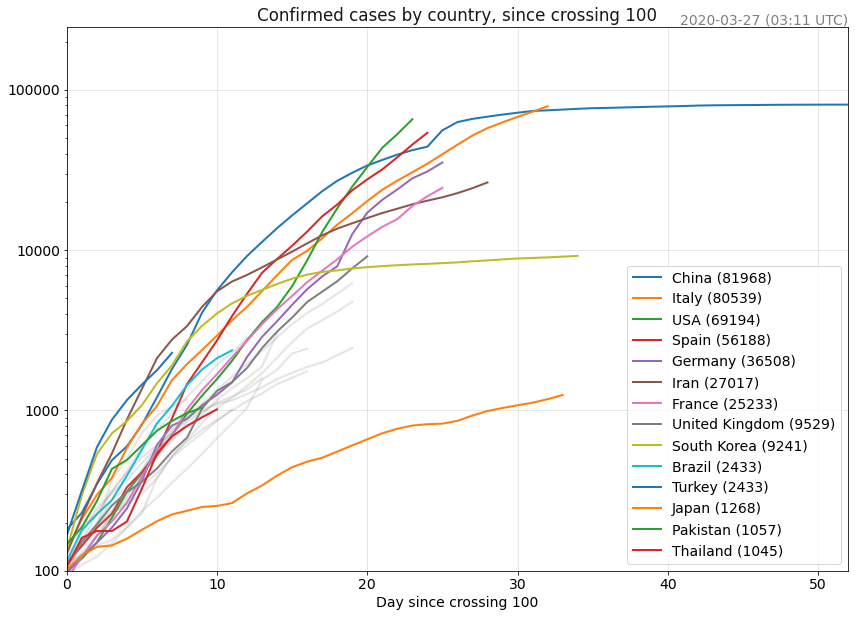

In [146]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.rc('font', size=14)

# config
metric = 'Confirmed'
x_metric = 'Day_of_2020'
shift_x_to_metric = 100
country_names_to_plot = countries_latest_top['CountryName']
gray_population_below = 40E+06


# label the plot
plt.figure(figsize=(14, 10))
if shift_x_to_metric:
    plt.title(metric + " cases by country, since crossing " + str(shift_x_to_metric), alpha=0.9)
    plt.xlabel("Day since crossing " + str(shift_x_to_metric))
else:
    plt.title(metric + " cases by country, since Feb 1st", alpha=0.9)
    plt.xlabel("Day of the year, 2020")
#plt.ylabel("Total " + metric + " cases")
plt_note_text = "" + datetime.now().strftime("%Y-%m-%d (%H:%M UTC)")


# add the lines for all the 'countries to chart'
max_x = 0
max_y = 0
for country_name in country_names_to_plot:
    # [select rows] get the data of a single country
    df = countries_daily[countries_daily['CountryName'] == country_name]

    # [cleanup] remove 0 , as they don't play well with log
    df = df[df[metric] > 0]

    # format the color and size
    latest_population = df['Population'].iloc[-1].astype(int)
    gray_line = latest_population < gray_population_below
    line_color = (0.5, 0.5, 0.5, 0.2) if gray_line else None

    # format the label (and shorten 'USA')
    line_label = country_name if country_name != "United States of America" else "USA"
    latest_metric = df[metric].iloc[-1].astype(int)
    line_label = line_label + " (" + str(latest_metric) + ")"
    if gray_line: line_label = None

    # find when the series crosses 100
    dx = 0
    if shift_x_to_metric:
        exceeding = df[df[metric] >= shift_x_to_metric]
        if len(exceeding) == 0:
            break
        dx = exceeding.iloc[0][x_metric]

    # add the data for this country
    x = (df[x_metric] - dx).tolist()
    y = df[metric].tolist()
    y_filtered = df[metric].rolling(window=(7, 20), win_type='exponential').mean()
    plt.plot(x, y, color=(0.8, 0.8, 0.8, 0.1), linewidth=1)
    plt.plot(x, y_filtered, label=line_label, color=line_color, linewidth=2)
    #plt.scatter(x, y, color=line_color, linewidth=1, alpha=1)

    # auto bounds
    if x[-1] > max_x: max_x = x[-1]
    if y[-1] > max_y: max_y = y[-1]


# X/Y axes: set-up ranges and scale type
plt.yscale('log')
if shift_x_to_metric:
    plt.xlim(0, max_x - 15)
    plt.ylim(shift_x_to_metric, 3 * max_y)
else:
    plt.xlim(date_to_day_of_year(datetime(2020, 2, 1)), max_x + 0.5)
    plt.ylim(10, 4 * max_y)
plt.gca().yaxis.set_major_formatter(ScalarFormatter())

# add grid
plt.gca().grid(axis='both', color=(0.4, 0.4, 0.4), alpha=0.2)

# add legend
plt.legend()

# add a text box with the current date
plt.text(1, 1, plt_note_text, transform=plt.gca().transAxes, horizontalalignment='right', verticalalignment='bottom', alpha=0.5)
#plt.text(1, -0.04, "Countries with >1M people and >1K cases", transform=plt.gca().transAxes, horizontalalignment='right', verticalalignment='top', alpha=0.5)

plt.show()